In [ ]:
#| default_exp kalman
%load_ext autoreload
%autoreload 2
import jax
jax.config.update("jax_enable_x64", True)

In [ ]:
# | export
import jax.numpy as jnp
import jax.random as jrn
import jax.scipy.linalg as jsla
import tensorflow_probability.substrates.jax.distributions as tfd
from jax import vmap, jit
from jax.lax import scan
from jaxtyping import Array, Float, PRNGKeyArray

from isssm.typing import GLSSM, FilterResult, Observations, SmootherResult
from isssm.util import MVN_degenerate as MVN, mm_sim

In [ ]:
# libraries for this notebook
from isssm.models.stsm import stsm
import jax
import numpy.testing as npt
import matplotlib.pyplot as plt
from isssm.glssm import simulate_glssm
from isssm.typing import GLSSM

# Kalman filter and smoother variants in JAX
> See also the corresponding [section in my thesis](https://stefanheyder.github.io/dissertation/thesis.pdf#nameddest=section.3.2)

Consider a [GLSSM](00_glssm.ipynb) of the form
$$
\begin{align*}
    X_0 &\sim \mathcal N (u_0, \Sigma_0) &\\
    X_{t + 1} &= u_{t + 1} + A_t X_{t} + \varepsilon_{t + 1} &t = 0, \dots, n - 1\\
    \varepsilon_t &\sim \mathcal N (0, \Sigma_t) & t = 1, \dots, n \\
    Y_t &= v_{t} + B_t X_t + \eta_t & t =0, \dots, n & \\
    \eta_t &\sim \mathcal N(0, \Omega_t), & t=0, \dots, n.
\end{align*}
$$


## Kalman Filter
For $t, s \in \{0, \dots, n\}$ consider the following BLPs and associated covariance matrices
$$
\begin{align*}
    \hat X_{t|s} &= \mathbf E \left( X_t | Y_s, \dots, Y_0\right) \\
    \Xi_{t | s} &= \text{Cov} \left(X_t | Y_s, \dots, Y_0 \right)\\
    \hat Y_{t|s} &= \mathbf E \left( Y_t | Y_s, \dots, Y_0\right) \\
    \Psi_{t | s} &= \text{Cov} \left(Y_t | Y_s, \dots, Y_0 \right)
\end{align*}
$$

The Kalman filter consists of the following two-step recursion:

#### Initialization
$$
\begin{align*}
\hat X_{0|0} &= u_0\\
\Xi_{0|0} &= \Sigma_0
\end{align*}
$$

Iterate for $t = 0, \dots, n-1$

#### Prediction
$$
\begin{align*}
    \hat X_{t + 1|t} &= u_{t + 1} + A_t \hat X_{t | t} \\
    \Xi_{t + 1 | t} &= A_t \Xi_{t|t} A_t^T + \Sigma_t\\
\end{align*}
$$

#### Filtering
$$
\begin{align*}
    \hat Y_{t + 1 | t} &= v_{t} + B_t \hat X_{t + 1 | t} \\
    \Psi_{t + 1| t} &= B_{t + 1} \Xi_{t + 1 | t} B_{t + 1}^T + \Omega_{t + 1}\\
    K_t &= \Xi_{t + 1 | t} B_{t + 1}^T \Psi_{t + 1 | t} ^{-1} \\
    \hat X_{t + 1 | t + 1} &= \hat X_{t + 1 | t} + K_t (Y_{t + 1} - \hat Y_{t + 1 | t})\\
    \Xi_{t + 1 | t + 1} &= \Xi_{t + 1 | t} - K_t \Psi_{t + 1| t} K_t^T 
\end{align*}
$$


In [ ]:
# | export

from isssm.util import append_to_front


def _predict(
    x_filt: Float[Array, "m"],  # $X_{t|t}$
    Xi_filt: Float[Array, "m m"],  # $\Xi_{t|t}
    u: Float[Array, "m"],  # $u_{t + 1}$
    A: Float[Array, "m m"],  # $A_t$
    Sigma: Float[Array, "l l"],  # $\Sigma_{t + 1}
    D: Float[Array, "m l"],
):
    """perform a single prediction step"""
    x_pred = A @ x_filt + u
    Xi_pred = A @ Xi_filt @ A.T + D @ Sigma @ D.T

    return x_pred, Xi_pred


def _filter(
    x_pred: Float[Array, "m"],
    Xi_pred: Float[Array, "m m"],
    y: Float[Array, "p"],
    v: Float[Array, "p"],
    B: Float[Array, "p m"],
    Omega: Float[Array, "p p"],
):
    """perform a single filtering step"""
    y_pred = v + B @ x_pred
    Psi_pred = B @ Xi_pred @ B.T + Omega
    K = (
        Xi_pred @ B.T @ jnp.linalg.pinv(Psi_pred, hermitian=True)
    )  # jsla.solve(Psi_pred, B).T
    x_filt = x_pred + K @ (y - y_pred)
    Xi_filt = Xi_pred - K @ Psi_pred @ K.T

    return x_filt, Xi_filt


def kalman(
    y: Observations,  # observatoins
    glssm: GLSSM,  # model
) -> FilterResult:  # filtered & predicted states and covariances
    """Perform the Kalman filter"""
    u, A, D, Sigma0, Sigma, v, B, Omega = glssm
    np1, p, m = B.shape
    _, m, l = D.shape

    def step(carry, inputs):
        x_filt, Xi_filt = carry
        y, u, A, D, Sigma, v, B, Omega = inputs

        x_pred, Xi_pred = _predict(x_filt, Xi_filt, u, A, Sigma, D)
        x_filt_next, Xi_filt_next = _filter(x_pred, Xi_pred, y, v, B, Omega)

        return (x_filt_next, Xi_filt_next), (x_filt_next, Xi_filt_next, x_pred, Xi_pred)

    # artificial state X_{-1} with mean x_0
    # covariance Sigma_0, transition identity and innovation cov 0
    # will lead to X_0 having correct predictive distribution
    # this avoids having to compute a separate filtering step beforehand

    A_ext = append_to_front(jnp.eye(m), A)
    Sigma_ext = append_to_front(jnp.zeros((l, l)), Sigma)
    D_ext = append_to_front(jnp.zeros((m, l)), D)
    u_ext = append_to_front(jnp.zeros(m), u[1:])

    init = (u[0], Sigma0)

    _, (x_filt, Xi_filt, x_pred, Xi_pred) = scan(
        step, init, (y, u_ext, A_ext, D_ext, Sigma_ext, v, B, Omega)
    )

    return FilterResult(x_filt, Xi_filt, x_pred, Xi_pred)

Let us check that our implementation works as expected by simulating a single sample from the joint distribution of a [structural time series model](models/10_stsm.ipynb) with seasonality of order 2. 

In [ ]:
glssm_model = stsm(jnp.ones(3), 0.0, 0.1, 0.1, 100, jnp.eye(3), 3, 2)

key = jrn.PRNGKey(53405234)
key, subkey = jrn.split(key)
(x,), (y,) = simulate_glssm(glssm_model, 1, subkey)

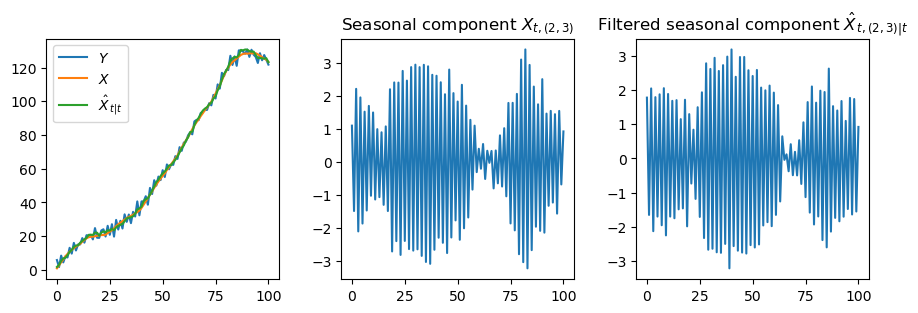

In [ ]:
x_filt, Xi_filt, x_pred, Xi_pred = kalman(y, glssm_model)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
fig.tight_layout()

ax1.set_title("")
ax1.plot(y, label="$Y$")
ax1.plot(x[:, 0], label="$X$")
ax1.plot(x_filt[:, 0], label="$\\hat X_{{t|t}}$")
ax1.legend()

ax2.plot(x[:, 2:])
ax2.set_title("Seasonal component $X_{{t, (2,3)}}$")

ax3.set_title("Filtered seasonal component $\\hat X_{{t, (2,3)|t}}$")
ax3.plot(x_filt[:, 2:])

plt.show()

Let us hasten to add that there is no reason to believe that $X_{t}$ and $\hat X_{t|n}$ should be close. Nevertheless, we can use this comparison as a sanity check whether our implementation gives reasonable estimates.

## Kalman smoother

The **Kalman smoother** uses the filter result to obtain $\hat X_{t | n}$ and $\Xi_{t | n}$ for $t = 0, \dots n$.

It is based on the following recursion with initialisation by the filtering result $\hat X_{n | n}$ and $\Xi_{n|n}$ and the (reverse) **gain** $G_t$. 

$$
\begin{align*}
    G_t &= \Xi_{t | t} A_t \Xi_{t + 1 | t} ^{-1}\\
    \hat X_{t | n} &= \hat X_{t | t} + G_t (\hat X_{t + 1| n} - \hat X_{t + 1 | t}) \\
    \Xi_{t | n} &= \Xi_{t | t} - G_t (\Xi_{t + 1 | t} - \Xi_{t + 1 | n}) G_t^T
\end{align*}
$$

In [ ]:
# | export
State = Float[Array, "m"]
StateCov = Float[Array, "m m"]
StateTransition = Float[Array, "m m"]


def _smooth_step(
    x_filt: State,
    x_pred_next: State,
    x_smooth_next: State,
    Xi_filt: StateCov,
    Xi_pred_next: StateCov,
    Xi_smooth_next: StateCov,
    A: StateTransition,
):
    err = x_smooth_next - x_pred_next
    Gain = Xi_filt @ A.T @ jnp.linalg.pinv(Xi_pred_next, hermitian=True)

    x_smooth = x_filt + Gain @ err
    Xi_smooth = Xi_filt - Gain @ (Xi_pred_next - Xi_smooth_next) @ Gain.T

    return (x_smooth, Xi_smooth)


def smoother(
    filter_result: FilterResult, A: Float[Array, "n m m"]  # transition matrices
) -> SmootherResult:
    """perform the Kalman smoother"""
    x_filt, Xi_filt, x_pred, Xi_pred = filter_result

    def step(carry, inputs):
        x_smooth_next, Xi_smooth_next = carry
        x_filt, Xi_filt, x_pred_next, Xi_pred_next, A = inputs

        x_smooth, Xi_smooth = _smooth_step(
            x_filt, x_pred_next, x_smooth_next, Xi_filt, Xi_pred_next, Xi_smooth_next, A
        )

        return (x_smooth, Xi_smooth), (x_smooth, Xi_smooth)

    _, (x_smooth, Xi_smooth) = scan(
        step,
        (x_filt[-1], Xi_filt[-1]),
        (x_filt[:-1], Xi_filt[:-1], x_pred[1:], Xi_pred[1:], A),
        reverse=True,
    )

    x_smooth = jnp.concatenate([x_smooth, x_filt[None, -1]])
    Xi_smooth = jnp.concatenate([Xi_smooth, Xi_filt[None, -1]])

    return SmootherResult(x_smooth, Xi_smooth)

Let us apply the Kalman smoother to our simulated observations.

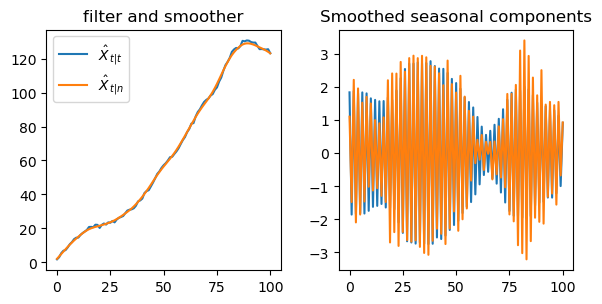

In [ ]:
filtered = kalman(y, glssm_model)

x_smooth, Xi_smooth = smoother(filtered, glssm_model.A)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
fig.tight_layout()
ax1.set_title("filter and smoother")
ax1.plot(x_filt[:, 0], label="$\\hat X_{{t | t}} $")
ax1.plot(x_smooth[:, 0], label="$\\hat X_{{t | n}}$")
ax1.legend()

ax2.set_title("Smoothed seasonal components")
ax2.plot(x_smooth[:, 2])
ax2.plot(x[:, 2])

plt.show()

The smoothed states are indeed smoother.

## Missing observations

When entries of $Y_{t}$ are missing, we can adapt the model by updating both $A_{t}$ and $\Omega_{t}$. Let $$M_{t} = \operatorname{diag} \left( \mathbf 1_{Y_{t, 1} \text{ observed}}, \dots, \mathbf 1_{Y_{t, p} \text{ observed}}\right),$$ then we replace $A_{t}$ by $M_{t}A_{t}$ and $\Omega_{t} = M_{t}\Omega_{t}M_{t}^{T}$, see also section 4.10 in [@Durbin2012Time].


In [ ]:
# | export


# y not jittable: boolean indices have to be concrete
def account_for_nans(model: GLSSM, y: Observations) -> tuple[GLSSM, Observations]:
    u, A, D, Sigma0, Sigma, v, B, Omega = model

    missing_indices = jnp.isnan(y)

    y = jnp.nan_to_num(y, nan=0.0)

    v = v.at[missing_indices].set(0.0)
    B = B.at[missing_indices].set(0.0)
    # set rows and columns of Omega to 0.
    Omega = Omega.at[missing_indices].set(0.0)
    Omega = Omega.transpose((0, 2, 1)).at[missing_indices].set(0.0)

    return GLSSM(u, A, D, Sigma0, Sigma, v, B, Omega), y

Let's try removing some observations in the middle. Notice that the filter essentially keeps the filtered states, only applying the systems dynamics to propagate the current best estimate. 

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


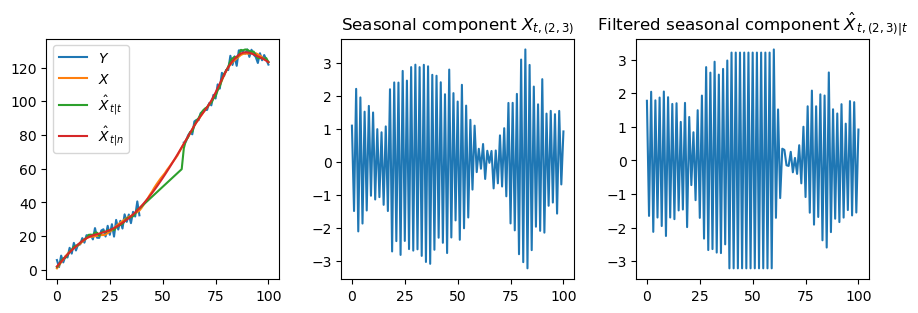

In [ ]:
y_missing = y.at[40:60].set(jnp.nan)
model_missing, y_accounted = account_for_nans(glssm_model, y_missing)
filter_result_missing = kalman(y_accounted, model_missing)
x_filt_missing, _, _, _ = filter_result_missing

x_smooth_missing, _ = smoother(filter_result_missing, model_missing.A)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
fig.tight_layout()

ax1.set_title("")
ax1.plot(y_missing, label="$Y$")
ax1.plot(x[:, 0], label="$X$")
ax1.plot(x_filt_missing[:, 0], label="$\\hat X_{{t|t}}$")
ax1.plot(x_smooth_missing[:, 0], label="$\\hat X_{{t|n}}$")
ax1.legend()

ax2.plot(x[:, 2:])
ax2.set_title("Seasonal component $X_{{t, (2,3)}}$")

ax3.set_title("Filtered seasonal component $\\hat X_{{t, (2,3)|t}}$")
ax3.plot(x_filt_missing[:, 2:])

plt.show()

## Prediction intervals

As the conditional distribution of states given observations is Gaussian, we can obtain marginal prediction intervals, i.e. for every individual state $X_{t, i}$, $t = 0, \dots, n$, $i = 1, \dots, m$, by using the Gaussian inverse CDF.

In [ ]:
# | export

from tensorflow_probability.substrates.jax.distributions import Normal


def filter_intervals(
    result: FilterResult, alpha: Float = 0.05
) -> Float[Array, "2 n+1 m"]:
    x_filt, Xi_filt, *_ = result
    marginal_variances = vmap(jnp.diag)(Xi_filt)
    dist = Normal(x_filt, marginal_variances)
    lower = dist.quantile(alpha / 2)
    upper = dist.quantile(1 - alpha / 2)

    return jnp.concatenate((lower[None], upper[None]))


def smoother_intervals(
    result: SmootherResult, alpha: Float = 0.05
) -> Float[Array, "2 n+1 m"]:
    x_smooth, Xi_smooth = result
    marginal_variances = vmap(jnp.diag)(Xi_smooth)
    dist = Normal(x_smooth, marginal_variances)
    lower = dist.quantile(alpha / 2)
    upper = dist.quantile(1 - alpha / 2)

    return jnp.concatenate((lower[None], upper[None]))

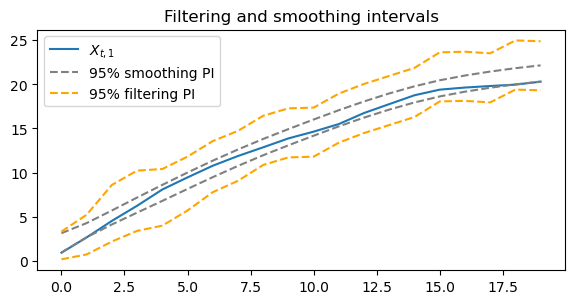

In [ ]:
filtered = kalman(y, glssm_model)
s_result = smoother(filtered, glssm_model.A)

s_lower, s_upper = smoother_intervals(s_result)
f_lower, f_upper = filter_intervals(filtered)

x_smooth, _ = s_result
fig, ax1 = plt.subplots(1, 1, figsize=(6, 3))
fig.tight_layout()
ax1.set_title("Filtering and smoothing intervals")
ax1.plot(x[:20, 0], label="$X_{t,1}$")
ax1.plot(s_lower[:20, 0], linestyle="--", color="grey")
ax1.plot(s_upper[:20, 0], linestyle="--", color="grey", label="95% smoothing PI")
ax1.plot(f_lower[:20, 0], linestyle="--", color="orange")
ax1.plot(f_upper[:20, 0], linestyle="--", color="orange", label="95% filtering PI")
ax1.legend()

plt.show()

## Sampling from the smoothing distribution

After having run the Kalman filter we can use a recursion due to Frühwirth-Schnatter [@Fruhwirth-Schnatter1994Data] to obtain samples from the joint conditional distribution the states given observations.

By the dependency structure of states and observations the conditional densities can be factorized in the following way:

$$
\begin{align*}
p(x_0, \dots, x_n | y_0, \dots, y_n) &=  p(x_n | y_0, \dots, y_n) \prod_{t = n - 1}^0 p(x_{t}| x_{t + 1}, \dots, x_n, y_0, \dots, y_n) \\
&= p(x_n | y_0, \dots, y_n) \prod_{t = n - 1}^0 p(x_{t}| x_{t + 1}, y_0, \dots, y_n)
\end{align*}
$$

and the conditional distributions are again gaussian with conditional expecatation 
$$
\mathbf E (X_{t} | X_{t + 1}, Y_0, \dots, Y_n) = \hat X_{t|t} + G_t (X_{t + 1} - \hat X_{t + 1|t})
$$ and conditional covariance matrix 
$$
\text{Cov} (X_t | X_{t + 1}, Y_0, \dots, Y_n) = \Xi_{t|t} - G_t\Xi_{t + 1 | t} G_t^T
$$

where $G_t = \Xi_{t|t} A_t^T \Xi_{t + 1|t}^{-1}$ is the smoothing gain.

In [ ]:
# | export
def _simulate_smoothed_FW1994(
    x_filt: Float[Array, "n+1 m"],
    Xi_filt: Float[Array, "n+1 m m"],
    Xi_pred: Float[Array, "n+1 m m"],
    A: Float[Array, "n m m"],
    N: int,  # number of samples
    key: PRNGKeyArray,  # the random states
) -> Float[Array, "N n+1 m"]:  # array of N samples from the smoothing distribution
    r"""Simulate from smoothing distribution $p(X_0, \dots, X_n|Y_0, \dots, Y_n)$"""

    key, subkey = jrn.split(key)
    X_n = MVN(x_filt[-1], Xi_filt[-1]).sample(N, subkey)

    def sample_backwards(carry, inputs):
        X_smooth_next, key = carry
        x_filt, Xi_filt, Xi_pred, A = inputs

        G = Xi_filt @ jnp.linalg.solve(Xi_pred, A).T

        cond_expectation = x_filt + mm_sim(G, X_smooth_next - (A @ x_filt)[None])
        cond_covariance = Xi_filt - G @ Xi_pred @ G.T

        key, subkey = jrn.split(key)
        new_samples = MVN(cond_expectation, cond_covariance).sample(seed=subkey)
        return (new_samples, key), new_samples

    key, subkey = jrn.split(key)
    _, X = scan(
        sample_backwards,
        (X_n, subkey),
        (x_filt[:-1], Xi_filt[:-1], Xi_pred[1:], A),
        reverse=True,
    )

    X_full = jnp.concatenate((X, X_n[None]))

    return X_full.transpose((1, 0, 2))


def FFBS(
    y: Observations,  # Observations $y$
    model: GLSSM,  # GLSSM
    N: int,  # number of samples
    key: PRNGKeyArray,  # random state
) -> Float[Array, "N n+1 m"]:  # N samples from the smoothing distribution
    r"""The Forward-Filter Backwards-Sampling Algorithm from [@Fruhwirth-Schnatter1994Data]."""
    x_filt, Xi_filt, _, Xi_pred = kalman(y, model)

    key, subkey = jrn.split(key)
    return _simulate_smoothed_FW1994(x_filt, Xi_filt, Xi_pred, model.A, N, subkey)

In [ ]:
key, subkey = jrn.split(key)
(X_sim,) = FFBS(y, glssm_model, 1, subkey)

assert X_sim.shape == x.shape

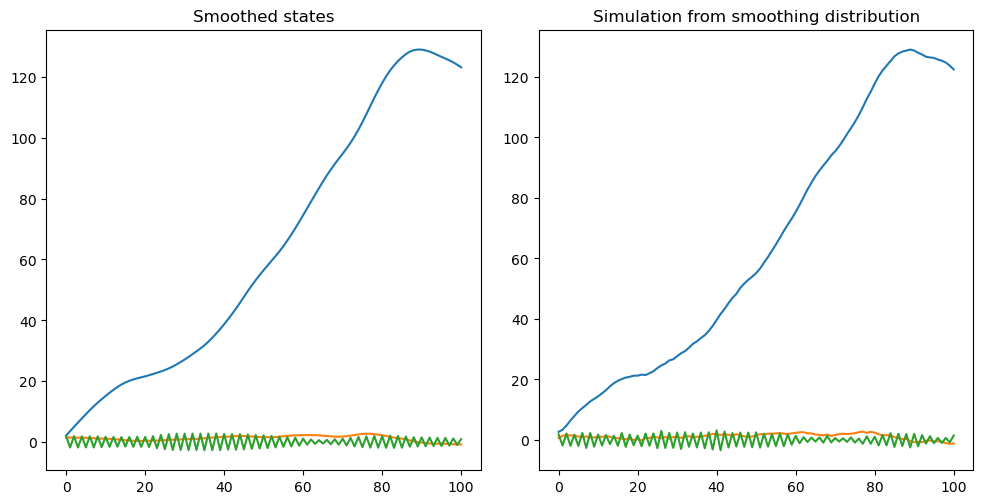

In [ ]:
x_smooth, Xi_smooth = smoother(filtered, glssm_model.A)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()
ax1.set_title("Smoothed states")
ax1.plot(x_smooth)
ax2.set_title("Simulation from smoothing distribution")
ax2.plot(X_sim)
plt.show()

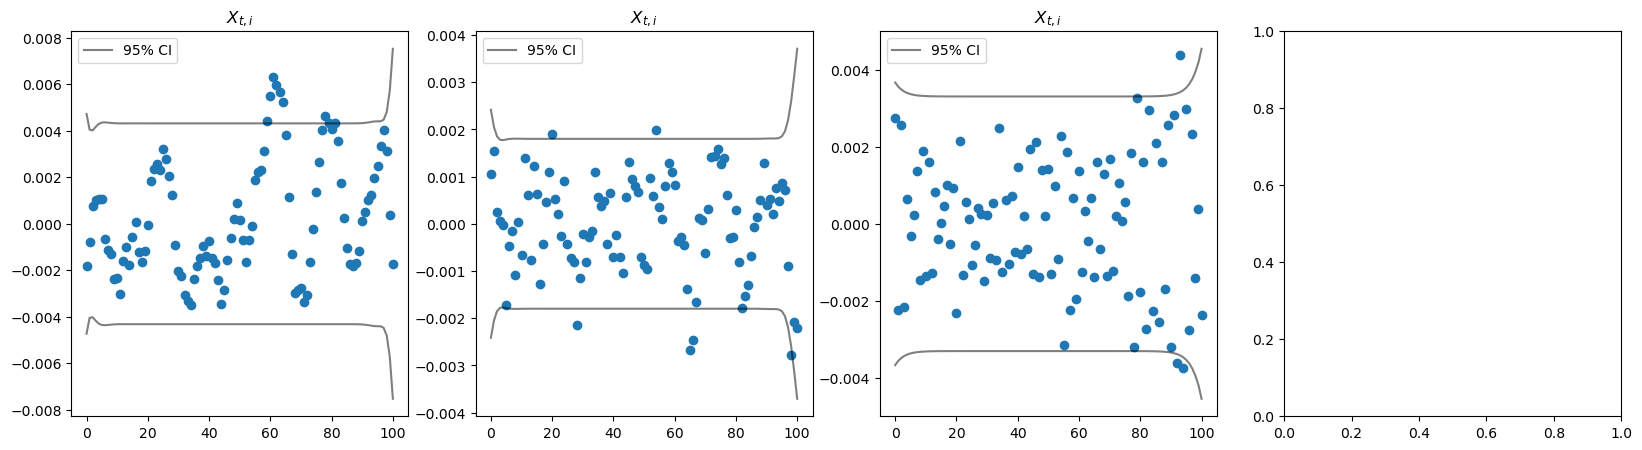

In [ ]:
# | hide
# sanity check: do marginal mean of simulation coincide with Kalman smoother?
key, subkey = jrn.split(key)
N = 1e5
X_sim = _simulate_smoothed_FW1994(x_filt, Xi_filt, Xi_pred, glssm_model.A, N, subkey)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
np1, p, m = glssm_model.B.shape
for i in range(m):
    axs[i].set_title("$X_{t, i}$")
    smoothed_vars = Xi_smooth[:, i, i]
    ci_bounds = 2 * jnp.sqrt(smoothed_vars) / jnp.sqrt(N)
    axs[i].plot(ci_bounds, color="black", alpha=0.5, label="95% CI")
    axs[i].plot(-ci_bounds, color="black", alpha=0.5)
    axs[i].scatter(jnp.arange(np1), X_sim[:, :, i].mean(axis=0) - x_smooth[:, i])
    axs[i].legend()
plt.show()

## The disturbance smoother

When the interest lies in the signal $S_{t} = B_{t}X_{t}$, $t = 0, \dots, n$, it is often more efficient to perform the following disturbance smoother, see Section 4.5 in [@Durbin2012Time] for details.
The recursions run from $t = n$ to $t = 0$ and are initialized by $r_n =0 \in \R^{m}$. While it is also possible to obtain smoothed state innovations $\hat \varepsilon_{t | n}$, we will not be interested in them in the following, so we skip them.

$$
\begin{align*}
    \hat\eta_{t | n} &= \Omega_{t} \left( \Psi_{t| t - 1}^{-1}(Y_{t} - Y_{t | t - 1}) - K_{t}^{T}A_{t}^{T}r_{t} \right) \\
    L_{t} &= A_{t} \left( I - K_{t}B_{t} \right) \\
    r_{t - 1} &= B_{t}^T \Psi_{t | t - 1}\left( Y_{t} - \hat Y_{t| t - 1} \right) + L_{t}^{T}r_{t} 
\end{align*}
$$
While it is also possible to derive smoothed covariance matrices, we will not need them, as we can use [the simulation smoother](#the-simulation-smoother), which is based on mean adjustments.


In [ ]:
# | export
from isssm.util import mm_time


def disturbance_smoother(
    filtered: FilterResult,  # filter result
    y: Observations,  # observations
    model: GLSSM,  # model
) -> Float[Array, "n+1 p"]:  # smoothed disturbances
    """perform the disturbance smoother for observation disturbances only"""
    x_filt, Xi_filt, x_pred, Xi_pred = filtered
    u, A, D, Sigma0, Sigma, v, B, Omega = model
    np1, p, m = B.shape

    def step(carry, inputs):
        (r,) = carry
        O_Pinv_y, O_KT_AT, BT_Pinv_y, L = inputs

        eta_smooth = O_Pinv_y - O_KT_AT @ r
        r_prev = BT_Pinv_y + L.T @ r

        return (r_prev,), eta_smooth

    A_ext = jnp.concatenate((A, jnp.eye(m)[jnp.newaxis]), axis=0)
    BT = B.transpose((0, 2, 1))

    # offline computation is faster
    y_tilde = y - mm_time(B, x_pred)
    Psi_pred = B @ Xi_pred @ BT + Omega
    Psi_pred_pinv = jnp.linalg.pinv(Psi_pred, hermitian=True)
    O_Pinv_y = mm_time(Omega @ Psi_pred_pinv, y_tilde)
    K = Xi_pred @ BT @ Psi_pred_pinv

    KT = K.transpose((0, 2, 1))
    AT = A_ext.transpose((0, 2, 1))
    O_KT_AT = Omega @ KT @ AT
    BT_Pinv_y = mm_time(BT @ Psi_pred_pinv, y_tilde)

    L = A_ext @ (jnp.eye(m)[None] - K @ B)

    _, eta_smooth = scan(
        step, (jnp.zeros(m),), (O_Pinv_y, O_KT_AT, BT_Pinv_y, L), reverse=True
    )

    return eta_smooth


def smoothed_signals(
    filtered: FilterResult,  # filter result
    y: Observations,  # observations
    model: GLSSM,  # model
) -> Float[Array, "n+1 m"]:  # smoothed signals
    """compute smoothed signals from filter result"""
    eta_smooth = disturbance_smoother(filtered, y, model)
    return y - eta_smooth

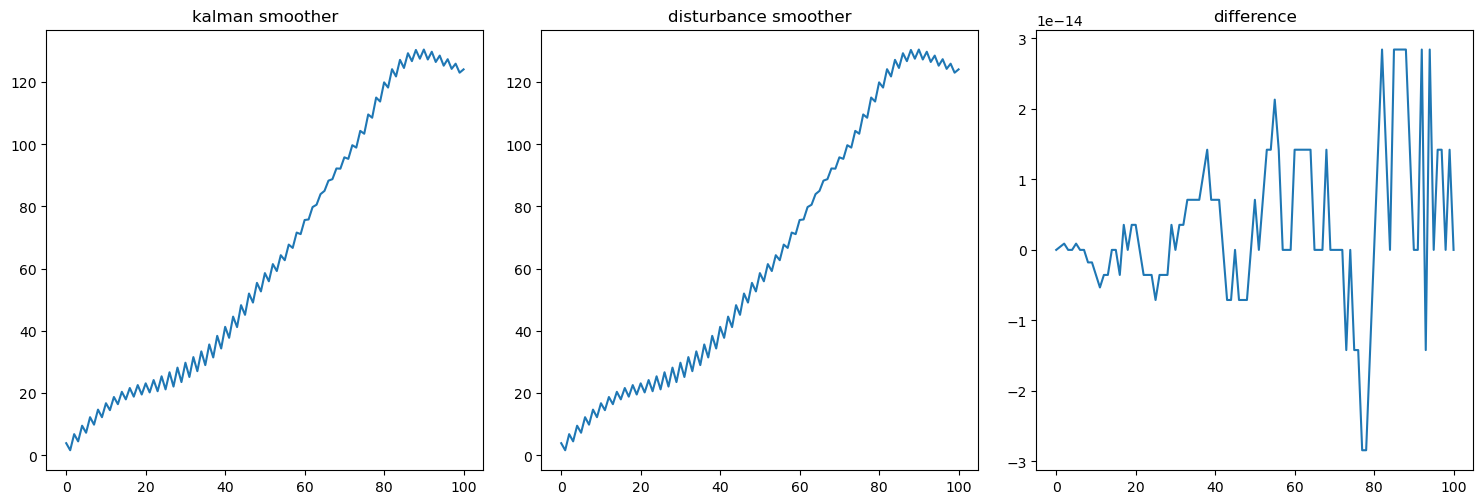

In [ ]:
s_smooth_ks = vmap(jnp.matmul)(glssm_model.B, x_smooth)
s_smooth = smoothed_signals(filtered, y, glssm_model)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.tight_layout()
ax1.set_title("kalman smoother")
ax1.plot(s_smooth_ks)
ax2.set_title("disturbance smoother")
ax2.plot(s_smooth)
ax3.set_title("difference")
ax3.plot(s_smooth_ks - s_smooth)
plt.show()

In [ ]:
vmm = vmap(jnp.matmul)
s_big = 100
big_model = stsm(jnp.zeros(2 + s_big - 1), 0., .1, .1, 100, jnp.eye(2 + s_big - 1), 3, s_big)
key, subkey = jrn.split(key)
_, (big_y,) = simulate_glssm(big_model, 1, subkey)
big_filtered = kalman(y, big_model)

%timeit smoothed_signals(big_filtered, big_y, big_model).block_until_ready()
%timeit vmm(big_model.B, smoother(big_filtered, big_model.A)[0]).block_until_ready()

48.4 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
322 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We see that for large state space, but low dimensional signal, the signal smoother drastically outperforms the simple smoother, and should be preferred if our main interest lies in the signals.

## The simulation smoother
The simulation smoother [@Durbin2002Simple] is a method for sampling from the smoothing distribution, without explicitly calculating conditional covariance matrices. It is based on the disturbance smoother. We will implement it for the signal only. 

1. Calculate the conditional expectation $\mathbf E \left( \eta_{t} | Y_{0} = y_{0}, \dots, Y_{n} = y_{n} \right)$ by the disturbance smoother.
2. Generate a new draw $(X^+, Y^+)$ from the state space model using innovations $\eta^+$.
3. Calculate the conditional expectation $\mathbf E \left( \eta^{+} | Y_{0} = y_{0}^+, \dots, Y_{n} = y_{n}^+\right)$ by the disturbance smoother.

Then
$$
\mathbf E \left( \eta_{t} | Y_{0} = y_{0}, \dots, Y_{n} = y_{n} \right)+ \left(\eta^{+} - \mathbf E \left( \eta^{+} | Y_{0} = y_{0}^+, \dots, Y_{n} = y_{n}^+\right)\right) 
$$ 
is a draw from the smoothing distribution $\eta | Y_{0} = y_{0}, \dots, Y_{n} = y_{n}$, because the second term is centered and independent from the first term. The first term contributes the mean, the second term the covariance.

In [ ]:
# | export
from tensorflow_probability.substrates.jax.distributions import Chi2
from isssm.util import degenerate_cholesky
from isssm.util import location_antithetic, scale_antithethic


def _sim_from_innovations_disturbances(
    model: GLSSM,
    x0: Float[Array, "N m"],
    eps: Float[Array, "N n l"],
    eta: Float[Array, "N n+1 p"],
) -> Float[Array, "N n+1 p"]:
    u, A, D, Sigma0, Sigma, v, B, Omega = model
    N, np1, l = eps.shape
    n, m, l = D.shape

    def step(carry, inputs):
        (x,) = carry
        u, A, D, eps, v, B, eta = inputs

        x_next = u + (A @ x[..., None])[..., 0] + mm_sim(D, eps)
        y_next = v + (B @ x[..., None])[..., 0] + eta

        return (x_next,), y_next

    A_ext = append_to_front(jnp.eye(m), A)
    u_ext = append_to_front(jnp.zeros(m), u[1:])
    D_ext = append_to_front(jnp.zeros((m, l)), D)
    eps_ext = append_to_front(jnp.zeros((N, l)), eps.transpose((1, 0, 2)))

    initial = (x0,)  # initial state
    (x,), y = scan(
        step,
        initial,
        (u_ext, A_ext, D_ext, eps_ext, v, B, eta.transpose(1, 0, 2)),
    )

    return y.transpose((1, 0, 2))


def simulation_smoother(
    model: GLSSM,  # model
    y: Observations,  # observations
    N: int,  # number of samples to draw
    key: PRNGKeyArray,  # random number seed
) -> Float[Array, "N n+1 m"]:  # N samples from the smoothing distribution of signals
    """Simulate from the smoothing distribution of signals"""
    np1, p, m = model.B.shape
    n, _, l = model.D.shape

    @jit
    def signal_filter_smoother(y, model):
        return smoothed_signals(kalman(y, model), y, model)

    key, subkey = jrn.split(key)
    u_x0 = MVN(jnp.zeros(m), jnp.eye(m)).sample(N, subkey)
    chol_Sigma0 = degenerate_cholesky(model.Sigma0)
    x0 = mm_sim(chol_Sigma0, u_x0)

    key, subkey = jrn.split(key)
    u_eps = MVN(jnp.zeros((n, l)), jnp.eye(l)[None]).sample(N, subkey)
    chol_Sigma = degenerate_cholesky(model.Sigma)
    eps = vmap(vmap(jnp.matmul), (None, 0))(chol_Sigma, u_eps)

    key, subkey = jrn.split(key)
    u_eta = MVN(jnp.zeros((np1, p)), jnp.eye(p)[None]).sample(N, subkey)
    chol_Omega = degenerate_cholesky(model.Omega)
    eta = vmap(vmap(jnp.matmul), (None, 0))(chol_Omega, u_eta)

    y_sim = _sim_from_innovations_disturbances(model, x0, eps, eta)

    signals_smooth = signal_filter_smoother(y, model)
    sim_signals = y_sim - eta
    sim_signals_smooth = vmap(signal_filter_smoother, (0, None))(y_sim, model)

    samples = signals_smooth[None] + (sim_signals - sim_signals_smooth)

    # u = jnp.concatenate((u_x0[:, None, :], u_eps, u_eta), axis=-1)
    u = jnp.concatenate(
        (u_x0.reshape((N, -1)), u_eps.reshape((N, -1)), u_eta.reshape((N, -1))), axis=1
    )

    l_samples = location_antithetic(samples, signals_smooth)
    s_samples = scale_antithethic(u, samples, signals_smooth)
    ls_samples = scale_antithethic(u, l_samples, signals_smooth)

    full_samples = jnp.concatenate((samples, l_samples, s_samples, ls_samples), axis=0)

    return full_samples

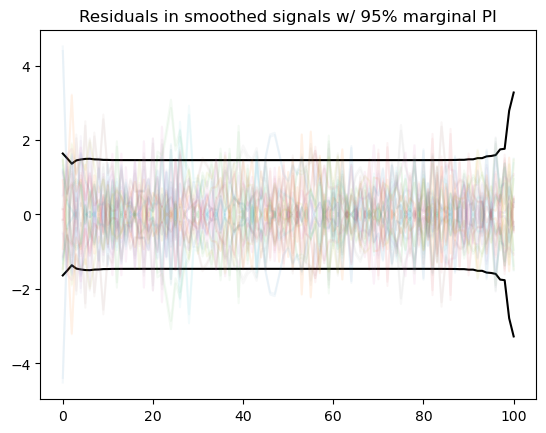

In [ ]:
smooth_signals_sim = simulation_smoother(glssm_model, y, 10, subkey)

signal_vars = vmap(lambda B, Xi: B @ Xi @ B.T)(glssm_model.B, Xi_smooth)[:, 0, 0]
plt.plot(2 * signal_vars, color="black", label="95% PI")
plt.title("Residuals in smoothed signals w/ 95% marginal PI")
plt.plot(-2 * signal_vars, color="black")
plt.plot(smooth_signals_sim[:, :, 0].T - s_smooth, alpha=0.05)
plt.show()

In [ ]:
vmm = vmap(vmap(jnp.matmul), (None, 0))
s_big = 300
big_model = stsm(jnp.zeros(2 + s_big - 1), 0., .1, .1, 100, jnp.eye(2 + s_big - 1), 3, s_big)
key, subkey = jrn.split(key)
_, (big_y,) = simulate_glssm(big_model, 1, subkey)
N = 100
key, subkey = jrn.split(key)

# ignore antithetics, could also be used for FFBS
%timeit simulation_smoother(big_model, big_y, N, subkey).block_until_ready()
%timeit vmm(big_model.B, FFBS(big_y, big_model, N, subkey)).block_until_ready()

974 ms ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.71 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Recovering states from signals

Both the signal and simulation smoother operate on the signals. If we are interested in the states, we have to recover them from the signals. As 

$$
    S_{t} = B_{t}X_{t}
$$

for all $t$, we can recover the mode (which is the mean in the Gaussian case) of the states by performing the Kalman-filter and smoother for the signal model, i.e. where we set $\Omega_t = \mathbf 0_{p\times p}$ and $y_t = s_t$. As the joint distribution of $(X,S)$ is Gaussian, the Kalman filter and smoother compute the conditional distribution $X | S$, which is Gaussian again and its mean coincides with its mode. 

In [ ]:
# | export
from isssm.typing import PGSSM


def to_signal_model(model: GLSSM | PGSSM):
    np1, p, _ = model.B.shape
    return GLSSM(
        model.u,
        model.A,
        model.D,
        model.Sigma0,
        model.Sigma,
        model.v,
        model.B,
        jnp.zeros((np1, p, p)),
    )


def state_conditional_on_signal(
    model: GLSSM | PGSSM, signal_mode: Float[Array, "n+1 p"]
):
    signal_model = to_signal_model(model)
    return smoother(kalman(signal_mode, signal_model), signal_model.A)


def state_mode(model: GLSSM | PGSSM, signal_mode: Float[Array, "n+1 p"]):
    return state_conditional_on_signal(model, signal_mode).x_smooth

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()